In [19]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Seed everything to make results reproducible
seed_everything(42)

In [20]:
import pandas as pd

# Load the main dataset
file_path = "dataset.tsv"
df = pd.read_csv(file_path, sep='\t')

In [21]:
# See examples from the dataset
df.head()

,Comment,Score,Link,Brand,Type
0,ürün güzel ve sağlam ulaştı..1 yıldız kırma se...,4,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
1,kaliteli hızlı kargo ve teslimat,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
2,"Ürün gayeten güzel, paketleme siz çok iyiydi.",5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
3,Cok guzeeeel,4,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television
4,Ürünüm koşa sürede hasarsız ulaştı kırık yoktu...,5,https://trendyol.com/onvo/32ov6000h-32-hd-read...,onvo,Television


In [22]:
# See score statistics
df.describe()

,Score
count,40450.000000
mean,4.588999
std,0.983537
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


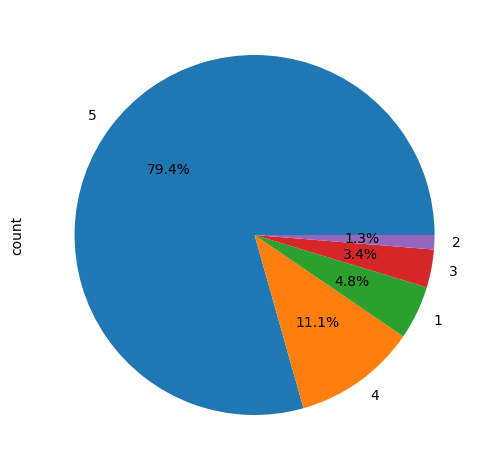

In [24]:
import matplotlib.pyplot as plt

# Plot the score distribution and use them in the final report
pie = df['Score'].value_counts().plot.pie(autopct='%1.1f%%')
fig = pie.get_figure()
fig.tight_layout()
fig.savefig("pie.pdf")

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import textacy
import textacy.preprocessing as tprep

stopwords = [tprep.remove.accents(word) for word in stopwords.words("turkish")]

# Tokenize the Turkish text so that it is ready to be used as features
def tokenize(text):
    text = text.lower()                                                           # lowercase the text
    text = text.translate(str.maketrans('', '', string.punctuation))              # remove punctuation
    text = tprep.normalize.unicode(text)                                          # normalize unicode
    text = tprep.remove.accents(text)                                             # remove accents
    text = word_tokenize(text, language='turkish')                                # split the text into words
    text = [word for word in text if not word in stopwords]                       # remove unnecessary noise words
    return text

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Score'], test_size=0.2, random_state=42)

In [9]:
# Convert the text into TF-IDF vectors
# Learn the vocabulary dictionary and return term-document matrix on the training set
# Transform documents to document-term matrix on the testing set

tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=tokenize)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.8217552533992583


In [11]:
# Train the final model with the best hyperparameters
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
predictions = best_rf_model.predict(X_test_tfidf)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate precision, recall, and F1 score
report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Display the classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nPrecision:", f"{(precision * 100):.2f}")
print("Recall:", f"{(recall * 100):.2f}")
print("F1 Score:", f"{(f1 * 100):.2f}")
print("Accuracy:", f"{(accuracy_score(y_test, predictions) * 100):.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.65      0.67       381
           2       0.00      0.00      0.00       113
           3       0.59      0.05      0.09       272
           4       0.55      0.03      0.06       937
           5       0.83      0.99      0.90      6387

    accuracy                           0.82      8090
   macro avg       0.53      0.34      0.35      8090
weighted avg       0.77      0.82      0.75      8090


Confusion Matrix:
 [[ 248    2    1    1  129]
 [  36    0    1    1   75]
 [  25    0   13   12  222]
 [  10    0    2   30  895]
 [  36    0    5   11 6335]]

Precision: 76.92
Recall: 81.90
F1 Score: 75.40
Accuracy: 81.90


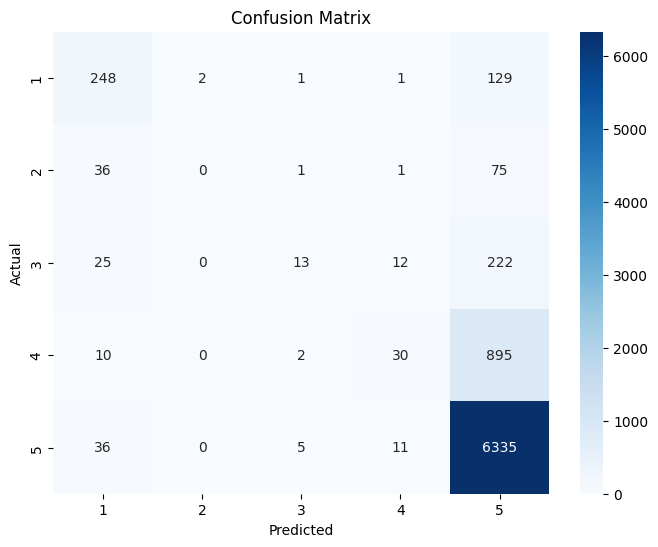

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

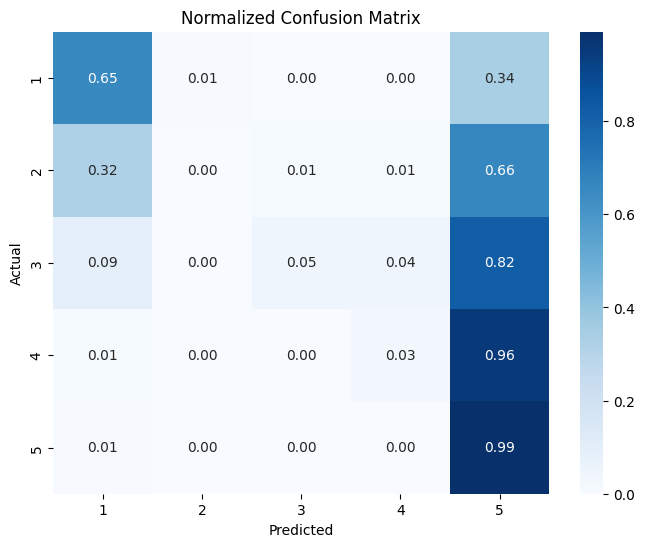

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix to analyze smaller classes better
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Save the predictions for statitical significance test
with open("rf_preds.npy", "wb") as f:
    np.save(f, predictions)

In [16]:
# Save the gold labels for statitical significance test
with open("rf_golds.npy", "wb") as f:
    np.save(f, y_test.to_numpy())

## OOD Part

In [25]:
import pandas as pd

# Load the OOD dataset
file_path = "OsmanBaturInce_ood_dataset.tsv"
df = pd.read_csv(file_path, sep='\t', header=None, names=["Comment", "Score", "Link", "Brand", "Type"])

In [18]:
# Just acquire the features and scores to make predictions with the best model
X = tfidf_vectorizer.transform(df["Comment"])
y = df["Score"]

In [19]:
# Perform predictions with the best model
predictions = best_rf_model.predict(X)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate precision, recall, and F1 score
report = classification_report(y, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Display the classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y, predictions))
print("\nPrecision:", f"{(precision * 100):.2f}")
print("Recall:", f"{(recall * 100):.2f}")
print("F1 Score:", f"{(f1 * 100):.2f}")
print("Accuracy:", f"{(accuracy_score(y, predictions) * 100):.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.38      0.45      0.42        11
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        36
           4       0.25      0.01      0.02       117
           5       0.87      0.99      0.93      1012

    accuracy                           0.86      1182
   macro avg       0.30      0.29      0.27      1182
weighted avg       0.77      0.86      0.80      1182


Confusion Matrix:
 [[   5    0    0    0    6]
 [   0    0    2    1    3]
 [   2    0    0    1   33]
 [   1    0    0    1  115]
 [   5    0    0    1 1006]]

Precision: 76.89
Recall: 85.62
F1 Score: 79.75
Accuracy: 85.62


/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [21]:
# Save the OOD predictions for statitical significance test
with open("rf_ood_preds.npy", "wb") as f:
    np.save(f, predictions)

In [22]:
# Save the OOD gold scores for statitical significance test
with open("rf_ood_golds.npy", "wb") as f:
    np.save(f, y.to_numpy())

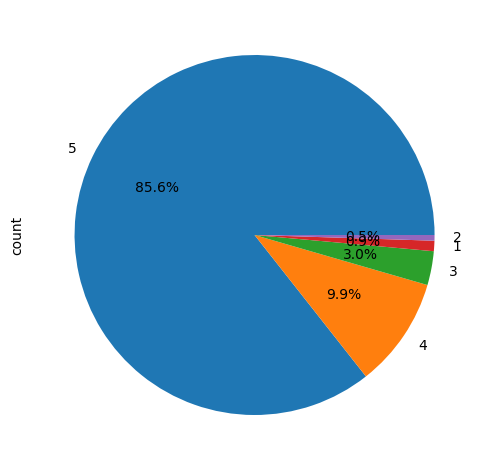

In [26]:
import matplotlib.pyplot as plt

# Create a pie chart to show the score distribution of the OOD dataset
pie = df['Score'].value_counts().plot.pie(autopct='%1.1f%%')
fig = pie.get_figure()
fig.tight_layout()
fig.savefig("ood.pdf")